In [1]:
#Evaluate ACCESS-OM2-01 IAF Properties in Denman Region
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean


In [3]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:40623 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


In [4]:
#load woa13 data .... this needs improvment, see issues
#The initial condition we used for the new 0.1deg IAF runs is actually here:
#/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc
#So you should compare ocean_temp_salt.res.nc to the model field "temp" (which is conservative temperature), not "pot_temp". 
#Also in ocean_temp_salt.res.nc the upper 1500m is monthly January mean; below that is boreal winter mean. So you should compare with the model in January. Not sure if that helps much either, as your monthly climatologies look pretty similar.
woa13=xr.open_mfdataset('/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc',engine='netcdf4',decode_times=False)
#woa13.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13

#v2 this is in potential temp (should be conservative, but minor issure). Also 12 months of data ... not sure what decade
#woa13=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
woa13v2=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
#woa13v2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13v2

<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 75, time: 12)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>

In [5]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [6]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [7]:
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [18]:
expt='01deg_jra55v140_iaf_cycle3'
start = '2010-01-01 00:00:00'
end = '2018-12-31 00:00:00'
salt = cc.querying.getvar(expt, variable='salt', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-60)).sel(xt_ocean=slice(-280,-250)).sel(time=slice(start,end)).chunk({'st_ocean':25, 'xt_ocean':1800})
salt

,Array,Chunk
Bytes,4.44 GiB,3.86 MiB
Shape,"(108, 75, 490, 300)","(1, 25, 135, 300)"
Count,402517 Tasks,1296 Chunks
Type,float32,numpy.ndarray


In [19]:
#longterm monthly mean data at 140E
var=salt.groupby('time.month').mean(dim='time') #.resample({'time':'M'})
var

<xarray.DataArray 'salt' (month: 12, st_ocean: 75, yt_ocean: 490, xt_ocean: 300)>
dask.array<stack, shape=(12, 75, 490, 300), dtype=float32, chunksize=(1, 25, 135, 300), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

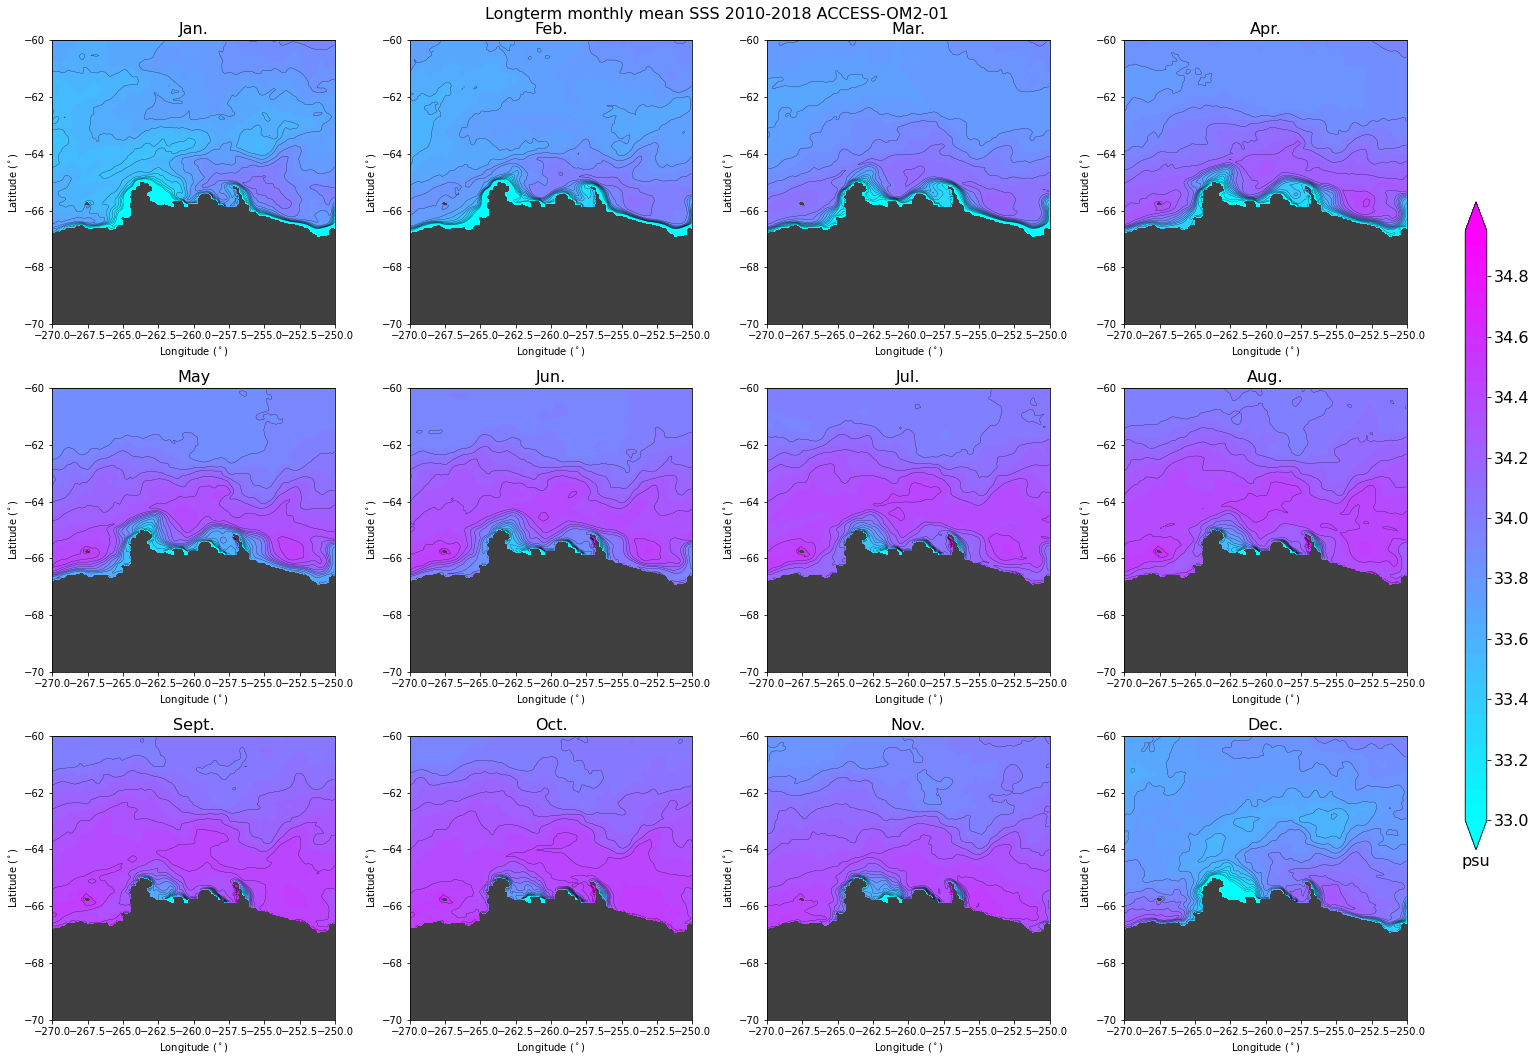

In [21]:
clev = np.arange(33,35,.05)
clev2 = np.arange(33,35,0.1)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean SSS 2010-2018 ACCESS-OM2-01',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.xt_ocean,var.yt_ocean,var[i,0,:,:],levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.xt_ocean,var.yt_ocean,var[i,0,:,:],levels=clev2,colors='k',linewidths=0.25)
    #plt.gca().invert_yaxis()
    #plt.ylim((1037.5,1034))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-70,-60])
    plt.xlim([-270,-250])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

In [22]:
var2=woa13v2.salt.sel(GRID_Y_T=slice(-90,-60)).sel(GRID_X_T=slice(-280,-250)).compute() #.mean(dim='time')
var3=var-var2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean','time': 'month'})

In [23]:
var3.load()
var3

<xarray.DataArray 'salt' (month: 12, st_ocean: 75, yt_ocean: 490, xt_ocean: 300)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-0.25883358, -0.2513714 , -0.25335625, ...,  0.00745485,
           0.0051726 ,  0.00446344],
         [-0.26100489, -0.25141984, -0.25207266, ...,  0.01220749,
           0.01162588,  0.01002482],
         [-0.25947152, -0.25001255, -0.25034719, ...,  0.0164939 ,
           0.01640434,  0.01568739]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... -250.2 -250.1 -250.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

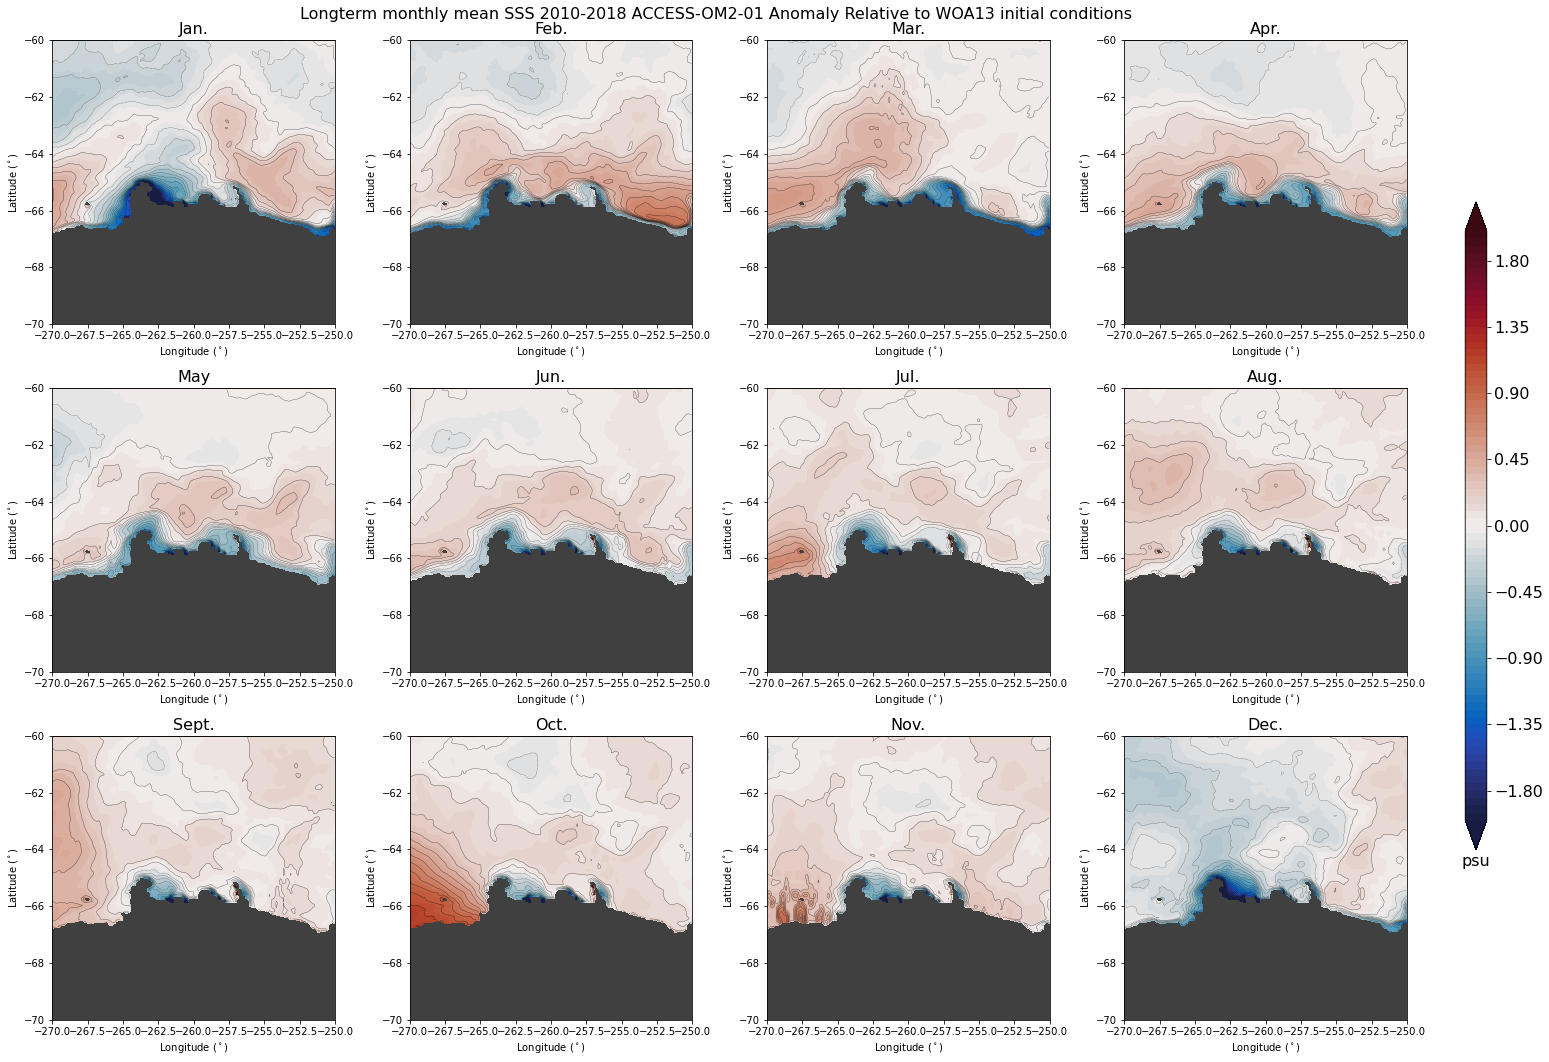

In [24]:
clev = np.arange(-2,2.05,.05)
clev2 = np.arange(-2,2.1,.1)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean SSS 2010-2018 ACCESS-OM2-01 Anomaly Relative to WOA13 initial conditions',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var3.xt_ocean,var3.yt_ocean,var3.isel(month=i).isel(st_ocean=0),levels=clev,cmap=cmocean.balance,colobar=True,extend='both')
    plt.contour(var3.xt_ocean,var3.yt_ocean,var3.isel(month=i).isel(st_ocean=0),levels=clev2,colors='k',linewidths=0.25)
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.ylim([-70,-60])
    plt.xlim([-270,-250])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()